# Kaggle: LLM Classification Finetuning


## 0. Environment and Dependencies

Primary libraries used in this notebook:

- `pandas`, `numpy`: data processing
- `matplotlib`, `seaborn`: visualization
- `scikit-learn`: dataset splitting and metrics (accuracy, log_loss)
- `transformers`, `datasets`, `torch`: LLM fine-tuning (e.g., DistilBERT)

Local environment (GPU setup):

- PyTorch: 2.7.1+cu118
- CUDA available: True
- CUDA version: 11.8
- GPU model: NVIDIA GeForce RTX 3050 Laptop GPU
- Current device: 0

Make sure all dependencies are installed before running the notebook.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

import torch
from datasets import Dataset
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

sns.set_theme(style="whitegrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    print(f"Current device: {torch.cuda.current_device()}")
print(f"Transformers version: {transformers.__version__}")
print(f"Python executable: {sys.executable}")

d:\Study_Project\Kaggle_LLM_Classification_Finetuning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU model: NVIDIA GeForce RTX 3050 Laptop GPU
Current device: 0
Transformers version: 5.2.0
Python executable: d:\Study_Project\Kaggle_LLM_Classification_Finetuning\.venv\Scripts\python.exe


In [2]:
import random
from transformers import set_seed

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

## 1. Data Loading

- Train set: `Dataset/train.csv`
- Test set: `Dataset/test.csv`

Train set columns:

- `id, model_a, model_b, prompt, response_a, response_b, winner_model_a, winner_model_b, winner_tie`

Test set columns:

- `id, prompt, response_a, response_b`

Goal: given the prompt and two responses, predict which response users prefer (A / B / tie).

In [3]:
train_path = os.path.join("Dataset", "train.csv")
test_path = os.path.join("Dataset", "test.csv")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (57477, 9)
Test shape: (3, 4)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


## 2. Exploratory Data Analysis (EDA)

Before training, visualize the dataset to understand its structure. Focus on:

- Label distribution (winner)
- Basic statistics and distributions of text lengths (prompt / response)
- A few sample rows to understand the task format

In [4]:
# Merge winner columns into a single label
def get_winner(row):
    if row["winner_model_a"] == 1:
        return "Model A"
    if row["winner_model_b"] == 1:
        return "Model B"
    return "Tie"

df_train["winner"] = df_train.apply(get_winner, axis=1)

df_train["winner"].value_counts()

winner
Model A    20064
Model B    19652
Tie        17761
Name: count, dtype: int64

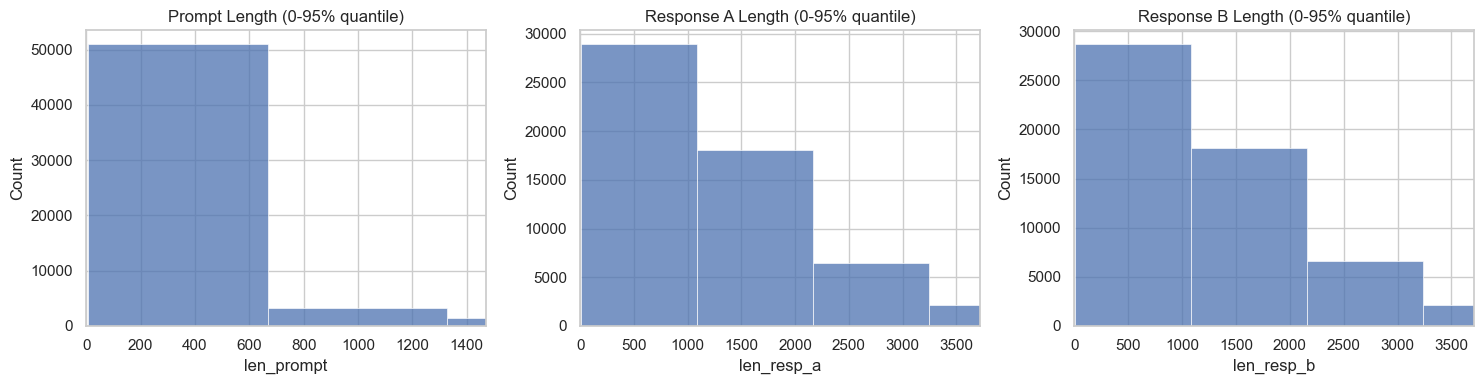

In [ ]:
# 1) the distribution of prompt, response_a, and response_b lengths
df_train["len_prompt"] = df_train["prompt"].astype(str).apply(len)
df_train["len_resp_a"] = df_train["response_a"].astype(str).apply(len)
df_train["len_resp_b"] = df_train["response_b"].astype(str).apply(len)

q_prompt = df_train["len_prompt"].quantile(0.95)
q_resp_a = df_train["len_resp_a"].quantile(0.95)
q_resp_b = df_train["len_resp_b"].quantile(0.95)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df_train["len_prompt"], bins=50, ax=axes[0])
axes[0].set_title("Prompt Length (0-95% quantile)")
axes[0].set_xlim(0, q_prompt)

sns.histplot(df_train["len_resp_a"], bins=50, ax=axes[1])
axes[1].set_title("Response A Length (0-95% quantile)")
axes[1].set_xlim(0, q_resp_a)

sns.histplot(df_train["len_resp_b"], bins=50, ax=axes[2])
axes[2].set_title("Response B Length (0-95% quantile)")
axes[2].set_xlim(0, q_resp_b)

plt.tight_layout()
plt.show()

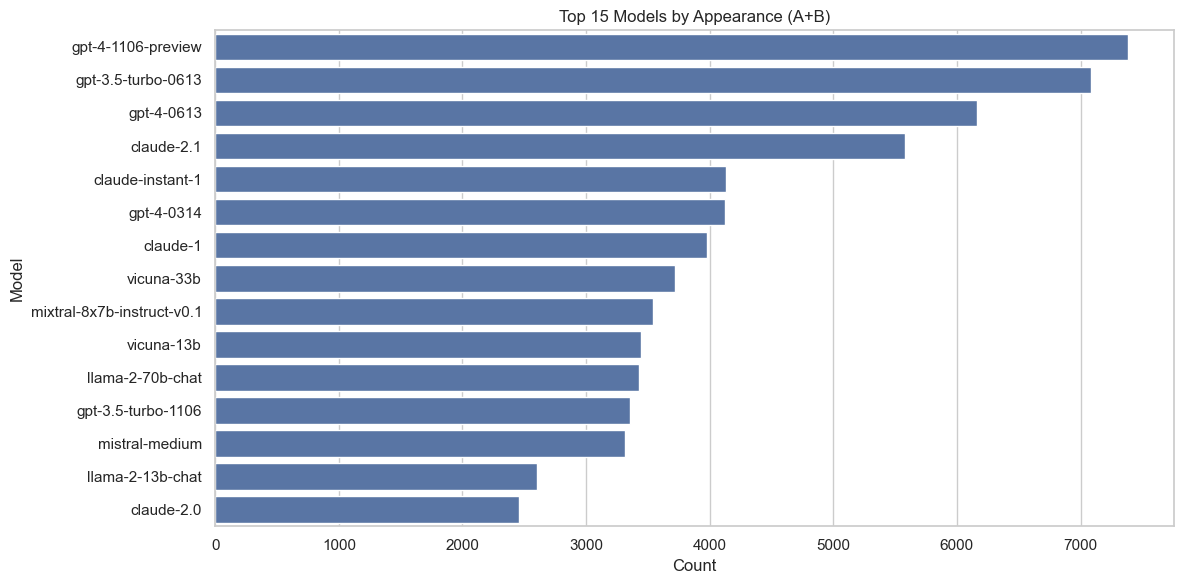

In [ ]:
# 2) model_a and model_b appearance frequency
model_counts = pd.concat([
    df_train["model_a"].value_counts(),
    df_train["model_b"].value_counts()
], axis=1, keys=["model_a", "model_b"]).fillna(0).astype(int)

model_counts["total"] = model_counts["model_a"] + model_counts["model_b"]
top_models = model_counts.sort_values("total", ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_models["total"], y=top_models.index, color="#4C72B0")
plt.title("Top 15 Models by Appearance (A+B)")
plt.xlabel("Count")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

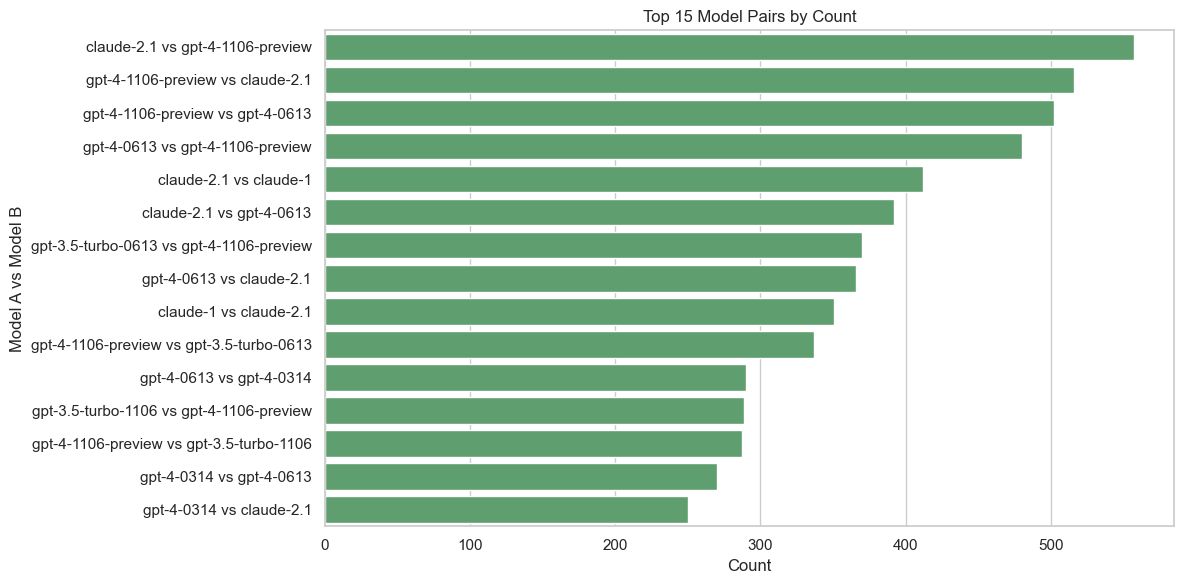

In [ ]:
# 3) model_a and model_b pair appearance frequency
pair_counts = (
    df_train.groupby(["model_a", "model_b"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(15)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=pair_counts,
    x="count",
    y=pair_counts["model_a"] + " vs " + pair_counts["model_b"],
    color="#55A868"
)
plt.title("Top 15 Model Pairs by Count")
plt.xlabel("Count")
plt.ylabel("Model A vs Model B")
plt.tight_layout()
plt.show()

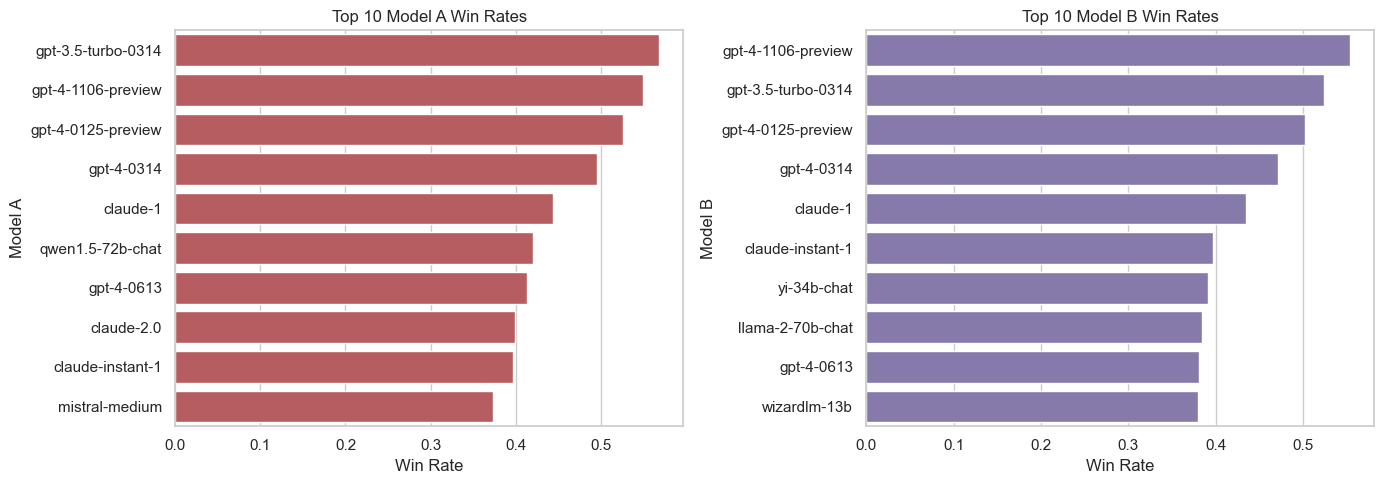

In [ ]:
# 4) model_a and model_b win rates
def calc_win_rate(df, model_col, win_col_name):
    win_rate = (
        df[df["winner"] == win_col_name]
        .groupby(model_col)
        .size()
        / df.groupby(model_col).size()
    ).fillna(0)
    return win_rate

model_a_win = calc_win_rate(df_train, "model_a", "Model A")
model_b_win = calc_win_rate(df_train, "model_b", "Model B")

top_a = model_a_win.sort_values(ascending=False).head(10)
top_b = model_b_win.sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=top_a.values, y=top_a.index, ax=axes[0], color="#C44E52")
axes[0].set_title("Top 10 Model A Win Rates")
axes[0].set_xlabel("Win Rate")
axes[0].set_ylabel("Model A")

sns.barplot(x=top_b.values, y=top_b.index, ax=axes[1], color="#8172B2")
axes[1].set_title("Top 10 Model B Win Rates")
axes[1].set_xlabel("Win Rate")
axes[1].set_ylabel("Model B")

plt.tight_layout()
plt.show()

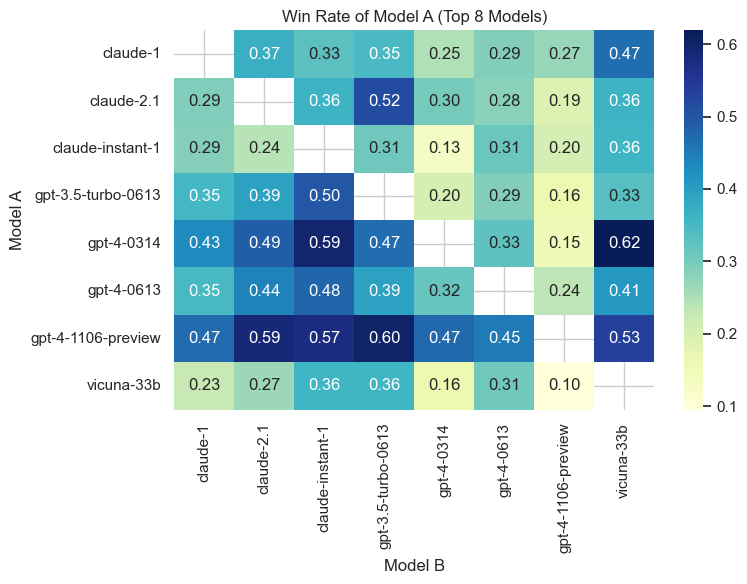

In [ ]:
# 5) model_a and model_b win rate heatmap (Top 8)
top_models_list = top_models.index[:8]
df_top = df_train[
    df_train["model_a"].isin(top_models_list) &
    df_train["model_b"].isin(top_models_list)
].copy()

pivot_win = df_top.pivot_table(
    index="model_a",
    columns="model_b",
    values="winner",
    aggfunc=lambda x: (x == "Model A").mean()
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_win, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Win Rate of Model A (Top 8 Models)")
plt.xlabel("Model B")
plt.ylabel("Model A")
plt.tight_layout()
plt.show()

In [ ]:
# 6) sample data view (Top 3)
df_train[["prompt", "response_a", "response_b", "winner"]].head(3)


,prompt,response_a,response_b,winner
0,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",Model A
1,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",Model B
2,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",Tie


## 3. Model Choice and Principles

This is a **text multi-class classification** task: given `(prompt, response_a, response_b)`, predict which response is preferred (or tie).

This notebook uses **DistilBERT** as the base model:

- DistilBERT is a distilled, smaller BERT with fewer parameters and faster inference, while preserving most semantic capability.
- Pretraining learns general language representations; fine-tuning maps them to the preference classification task.
- Model card and paper:
  - https://huggingface.co/distilbert-base-uncased
  - https://arxiv.org/abs/1910.01108

### Input Construction Strategy

We concatenate `(prompt, response_a, response_b)` into a single sequence so the model can compare both responses within one context window.

```text
Prompt: <prompt> \n Response A: <response_a> \n Response B: <response_b>
```

Why this works:
- Self-attention aligns key information across segments, learning prompt-response alignment and A/B differences.
- The classifier reads a single global representation (e.g., [CLS] or pooled embedding), effectively comparing all three segments.
- A fixed template (Prompt / Response A / Response B) makes the input structure explicit and stable.

The output layer is a 3-class classifier:
- Class 0: Model A wins
- Class 1: Model B wins
- Class 2: Tie

In [16]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

label2id = {"Model A": 0, "Model B": 1, "Tie": 2}
id2label = {v: k for k, v in label2id.items()}

df_train["label"] = df_train["winner"].map(label2id)
df_train["label"].value_counts()

label
0    20064
1    19652
2    17761
Name: count, dtype: int64

## 4. Metrics and Loss Function

### Loss Function

- For multi-class classification, the standard choice is **cross-entropy loss**.
- In `transformers`, `AutoModelForSequenceClassification` automatically applies cross-entropy when `labels` are provided.

### Metrics

- **Accuracy**: correct predictions / total samples.
- **Log Loss**: a Kaggle-standard metric that measures how close the predicted probability distribution is to the true labels (lower is better).

In the Trainer, we compute both metrics via a custom `compute_metrics` function.

In [ ]:
import json

def normalize_text(x):
    if x is None:
        return ""
    if pd.isna(x):
        return ""
    if isinstance(x, list):
        return " ".join([normalize_text(i) for i in x])
    if isinstance(x, dict):
        return " ".join([f"{k}:{normalize_text(v)}" for k, v in x.items()])
    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                v = json.loads(s)
                return normalize_text(v)
            except Exception:
                pass
        s = s.encode("utf-8", "ignore").decode("utf-8", "ignore")
        s = s.replace("\\/", "/")
        return s
    return str(x).encode("utf-8", "ignore").decode("utf-8", "ignore")

def build_text(df):
    prompt = df["prompt"].apply(normalize_text)
    resp_a = df["response_a"].apply(normalize_text)
    resp_b = df["response_b"].apply(normalize_text)
    model_a = df["model_a"].apply(normalize_text) if "model_a" in df.columns else ""
    model_b = df["model_b"].apply(normalize_text) if "model_b" in df.columns else ""
    return (
        "Model A: " + model_a + "\n" +
        "Model B: " + model_b + "\n" +
        "Prompt: " + prompt + "\n" +
        "Response A: " + resp_a + "\n" +
        "Response B: " + resp_b
    )

def encode_texts(texts, batch_size=1024):
    input_ids = []
    attention_mask = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            list(batch),
            truncation=True,
            max_length=512,
            padding=False,
        )
        input_ids.extend(enc["input_ids"])
        attention_mask.extend(enc["attention_mask"])
    return {"input_ids": input_ids, "attention_mask": attention_mask}

train_df, val_df = train_test_split(
    df_train,
    test_size=0.1,
    random_state=42,
    stratify=df_train["label"],
)

train_text = build_text(train_df)
val_text = build_text(val_df)
test_text = build_text(df_test)

train_enc = encode_texts(train_text)
val_enc = encode_texts(val_text)
test_enc = encode_texts(test_text)

train_enc["labels"] = train_df["label"].tolist()
val_enc["labels"] = val_df["label"].tolist()

train_enc = Dataset.from_dict(train_enc)
val_enc = Dataset.from_dict(val_enc)
test_enc = Dataset.from_dict(test_enc)

train_enc.set_format("torch")
val_enc.set_format("torch")
test_enc.set_format("torch")

<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: inv

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    try:
        ll = log_loss(labels, probs)
    except ValueError:
        ll = float("nan")
    return {"accuracy": acc, "log_loss": ll}

## 5. Model Building and Training

We build a 3-class model with `AutoModelForSequenceClassification`:

- `num_labels=3`
- `id2label` / `label2id` map class IDs to readable labels.

Key training parameters and what they do:
- `learning_rate`: step size; too large causes instability, too small slows convergence. Typical range: 1e-5 to 5e-5.
- `num_train_epochs`: number of full passes; higher can overfit. Monitor validation metrics as it increases.
- `per_device_train_batch_size`: batch size per GPU; limited by VRAM. Use gradient accumulation to simulate larger batches.
- `gradient_accumulation_steps`: accumulates gradients across steps; effective batch = batch_size × accumulation_steps.
- `weight_decay`: regularization to reduce overfitting; commonly 0.01.
- `fp16`: mixed precision for faster training and lower memory usage on GPUs.
- `eval_strategy` / `save_strategy`: evaluation and checkpointing cadence; must match when `load_best_model_at_end=True`.
- `logging_steps`: log interval for tracking loss.
- `save_total_limit`: limits checkpoint count to save disk space.
- `warmup_ratio` or `warmup_steps`: warms up the learning rate for stability.

Tuning tips:
- Start with fewer epochs and a smaller batch to validate the pipeline, then scale up.
- If validation loss rises, reduce epochs or increase regularization.
- When VRAM is limited, use gradient accumulation instead of a larger batch.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,  # increase learning rate

    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2, # increase gradient accumulation steps
    fp16=torch.cuda.is_available(),

    num_train_epochs=3,

    weight_decay=0.01,
    warmup_ratio=0.1, 

    lr_scheduler_type="cosine",
    label_smoothing_factor=0.05,
    max_grad_norm=1.0,
    optim="adamw_torch",
    
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    
    metric_for_best_model="log_loss",
    greater_is_better=False,
    logging_steps=50,
    report_to="none",
    seed=42,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience=3)], # add early stopping
)

trainer.train()
trainer.save_model("trained_model")
tokenizer.save_pretrained("trained_model")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1074.20it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Step,Training Loss,Validation Loss,Accuracy,Log Loss,Runtime,Samples Per Second,Steps Per Second
100,1.105461,1.098064,0.340292,1.098070,33.297700,172.625000,10.812000
200,1.096436,1.098012,0.341162,1.098010,34.137100,168.380000,10.546000
300,1.096296,1.096339,0.342728,1.096333,34.009700,169.010000,10.585000
400,1.096395,1.096681,0.352992,1.096683,33.513800,171.511000,10.742000
500,1.089233,1.096474,0.355428,1.096476,33.566500,171.242000,10.725000
600,1.091576,1.091262,0.372999,1.091259,33.233800,172.956000,10.832000
700,1.095829,1.098621,0.357342,1.098625,33.390500,172.145000,10.782000
800,1.111891,1.090329,0.370912,1.090334,34.071300,168.705000,10.566000
900,1.095653,1.088914,0.372129,1.088917,34.411700,167.036000,10.462000
1000,1.095322,1.091418,0.362213,1.091414,34.631800,165.975000,10.395000


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=19401, training_loss=1.0392737645450607, metrics={'train_runtime': 10798.6124, 'train_samples_per_second': 14.371, 'train_steps_per_second': 1.797, 'total_flos': 2.055758480403149e+16, 'train_loss': 1.0392737645450607, 'epoch': 3.0})

## 6. Validation Evaluation and Test Prediction

1. Evaluate on the validation set and report accuracy and log_loss.
2. Predict on the test set and generate `submission.csv` with:
   - `id`
   - `winner_model_a`, `winner_model_b`, `winner_tie` (predicted probabilities for each class).

In [ ]:
eval_results = trainer.evaluate()
print("Evaluation results:")
print(eval_results)

Evaluation results:
{'eval_loss': 1.0436153411865234, 'eval_accuracy': 0.4596381350034795, 'eval_log_loss': 1.0436119474286631, 'eval_runtime': 33.8308, 'eval_samples_per_second': 169.904, 'eval_steps_per_second': 10.641, 'epoch': 3.0}


In [ ]:
predictions = trainer.predict(test_enc)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

submission = pd.DataFrame({
    "id": df_test["id"],
    "winner_model_a": probs[:, 0],
    "winner_model_b": probs[:, 1],
    "winner_tie": probs[:, 2],
})

submission_path = "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")
submission.head()

Submission file saved to submission.csv


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.343558,0.247909,0.408533
1,211333,0.442657,0.289152,0.268190
2,1233961,0.356988,0.342407,0.300605


## 7. Summary

This notebook demonstrates:

- How to load and visualize Kaggle LLM Classification Finetuning `train.csv` / `test.csv` data
- How to combine three text fields (prompt, response_a, response_b) into one model input
- How to fine-tune a 3-class DistilBERT model with cross-entropy loss
- How to evaluate on the validation set (accuracy, log_loss)
- How to predict the test set and generate a submission file in the required format

You can extend this by:

- Trying a larger model or incorporating `model_a`/`model_b` as features
- Improving the input construction (e.g., encode A/B separately then compare)
- Adding richer visualizations and error analysis